# Phase -1: Data Acquisition & Infrastructure

This notebook documents the data acquisition and infrastructure setup for the GFlowNet peptide generation project.

**Objectives:**
- Download and validate FLIP Stability dataset
- Download and validate Propedia/PepBDB binding dataset
- Download and validate FLIP GB1 dataset (optional)
- Verify ESM-2 model functionality
- Test data loading pipeline

## 1. Setup

Import required libraries and set up paths.

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add parent directory to path if running from notebooks/
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Data paths
DATA_DIR = project_root / 'data'
OUTPUT_DIR = project_root / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {DATA_DIR}")

Project root: /home/ubuntu/storage1/gflownet-peptide
Data directory: /home/ubuntu/storage1/gflownet-peptide/data


## 2. Directory Structure

Verify the data directory structure exists.

In [2]:
# Verify directory structure
expected_dirs = [
    DATA_DIR / 'flip' / 'stability',
    DATA_DIR / 'flip' / 'gb1',
    DATA_DIR / 'propedia',
    DATA_DIR / 'processed',
]

print("Directory structure check:")
for d in expected_dirs:
    status = "✓" if d.exists() else "✗"
    print(f"  {status} {d.relative_to(project_root)}")

Directory structure check:
  ✓ data/flip/stability
  ✓ data/flip/gb1
  ✓ data/propedia
  ✓ data/processed


## 3. FLIP Stability Dataset

### 3.1 Load and Explore

The FLIP Stability (Meltome) dataset contains ~28K protein sequences with experimentally measured melting temperatures.

In [3]:
from gflownet_peptide.data import load_flip_stability, validate_sequence

# Load all data (no length filtering for exploration)
stability_path = DATA_DIR / 'flip' / 'stability'
seqs_all, labels_all = load_flip_stability(
    str(stability_path),
    min_length=1,
    max_length=10000,
    normalize=False
)

print(f"Total sequences: {len(seqs_all)}")
print(f"Label range: [{labels_all.min():.2f}, {labels_all.max():.2f}] °C")
print(f"Label mean: {labels_all.mean():.2f} °C")
print(f"Label std: {labels_all.std():.2f} °C")

Total sequences: 27863
Label range: [27.58, 98.99] °C
Label mean: 51.66 °C
Label std: 10.75 °C


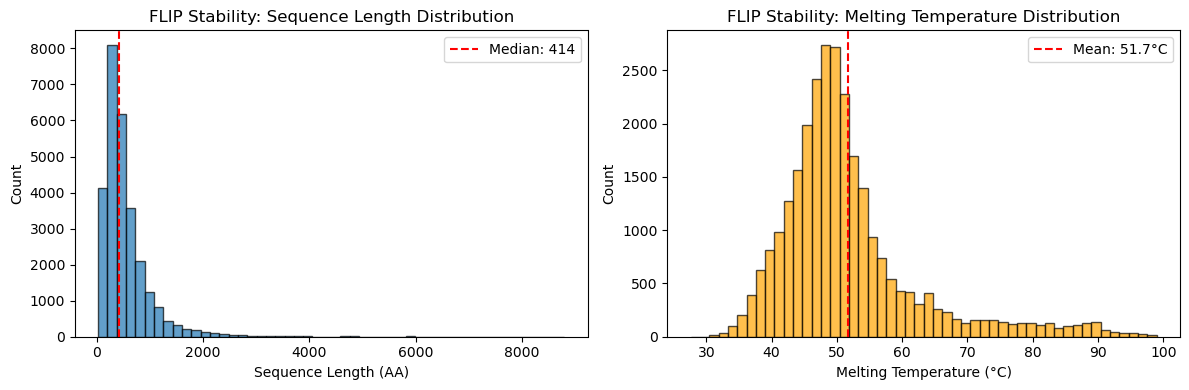


Figure saved to: /home/ubuntu/storage1/gflownet-peptide/outputs/flip_stability_distributions.png


In [4]:
# Sequence length distribution
lengths = [len(seq) for seq in seqs_all]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of lengths
axes[0].hist(lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sequence Length (AA)')
axes[0].set_ylabel('Count')
axes[0].set_title('FLIP Stability: Sequence Length Distribution')
axes[0].axvline(np.median(lengths), color='r', linestyle='--', label=f'Median: {np.median(lengths):.0f}')
axes[0].legend()

# Histogram of labels (melting temperature)
axes[1].hist(labels_all, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Melting Temperature (°C)')
axes[1].set_ylabel('Count')
axes[1].set_title('FLIP Stability: Melting Temperature Distribution')
axes[1].axvline(np.mean(labels_all), color='r', linestyle='--', label=f'Mean: {np.mean(labels_all):.1f}°C')
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'flip_stability_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {OUTPUT_DIR / 'flip_stability_distributions.png'}")

### 3.2 Verification

Verify data quality and split distribution.

In [5]:
# Load with train/val/test splits
train_seqs, train_labels = load_flip_stability(str(stability_path), split='train', normalize=False, min_length=1, max_length=10000)
test_seqs, test_labels = load_flip_stability(str(stability_path), split='test', normalize=False, min_length=1, max_length=10000)

print(f"Train sequences: {len(train_seqs)}")
print(f"Test sequences: {len(test_seqs)}")
print(f"\nAll sequences have canonical AA: {all(validate_sequence(s) for s in seqs_all)}")

Train sequences: 24736
Test sequences: 3127

All sequences have canonical AA: True


## 4. Propedia/PepBDB Dataset

### 4.1 Load and Explore

The Propedia/PepBDB dataset contains peptide sequences from structurally verified peptide-protein binding complexes.

In [6]:
from gflownet_peptide.data import load_propedia

# Load peptide data
propedia_path = DATA_DIR / 'propedia'
pep_seqs, pep_labels = load_propedia(
    str(propedia_path),
    min_length=10,
    max_length=50,
    normalize=False
)

print(f"Total peptides (10-50 AA): {len(pep_seqs)}")
print(f"Unique peptides: {len(set(pep_seqs))}")
print(f"All labels are 1.0 (binders): {all(l == 1.0 for l in pep_labels)}")

Total peptides (10-50 AA): 4821
Unique peptides: 4821
All labels are 1.0 (binders): True


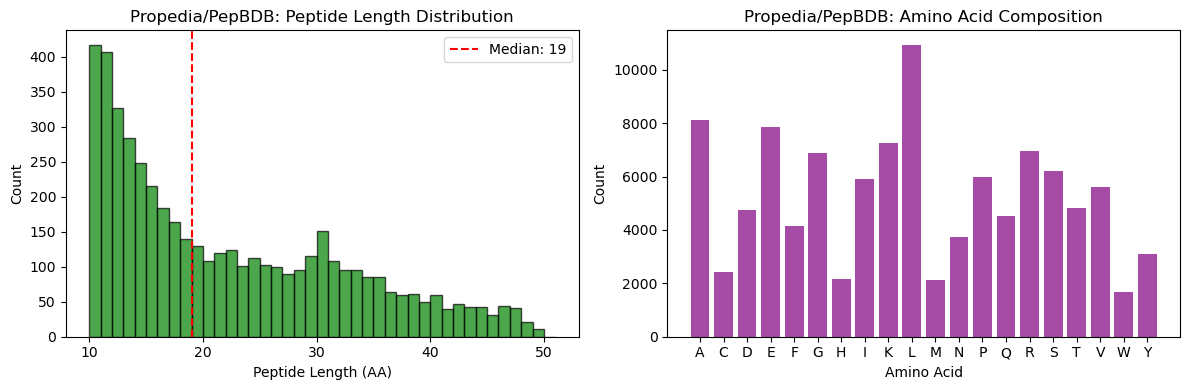


Figure saved to: /home/ubuntu/storage1/gflownet-peptide/outputs/propedia_distributions.png


In [7]:
# Peptide length distribution
pep_lengths = [len(seq) for seq in pep_seqs]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of lengths
axes[0].hist(pep_lengths, bins=range(10, 52), edgecolor='black', alpha=0.7, color='green')
axes[0].set_xlabel('Peptide Length (AA)')
axes[0].set_ylabel('Count')
axes[0].set_title('Propedia/PepBDB: Peptide Length Distribution')
axes[0].axvline(np.median(pep_lengths), color='r', linestyle='--', label=f'Median: {np.median(pep_lengths):.0f}')
axes[0].legend()

# Amino acid composition
aa_counts = {}
for seq in pep_seqs:
    for aa in seq:
        aa_counts[aa] = aa_counts.get(aa, 0) + 1

aa_sorted = sorted(aa_counts.keys())
counts = [aa_counts[aa] for aa in aa_sorted]
axes[1].bar(aa_sorted, counts, color='purple', alpha=0.7)
axes[1].set_xlabel('Amino Acid')
axes[1].set_ylabel('Count')
axes[1].set_title('Propedia/PepBDB: Amino Acid Composition')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'propedia_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {OUTPUT_DIR / 'propedia_distributions.png'}")

### 4.2 Verification

In [8]:
# Check splits
train_pep, _ = load_propedia(str(propedia_path), split='train', min_length=10, max_length=50)
val_pep, _ = load_propedia(str(propedia_path), split='val', min_length=10, max_length=50)
test_pep, _ = load_propedia(str(propedia_path), split='test', min_length=10, max_length=50)

print(f"Train peptides: {len(train_pep)}")
print(f"Val peptides: {len(val_pep)}")
print(f"Test peptides: {len(test_pep)}")
print(f"\nAll have canonical AA: {all(validate_sequence(s) for s in pep_seqs)}")

Train peptides: 3856
Val peptides: 482
Test peptides: 483

All have canonical AA: True


## 5. FLIP GB1 Dataset (Optional)

The GB1 dataset contains ~8.7K protein variants with measured binding fitness values.

In [ ]:
from gflownet_peptide.data import load_flip_gb1

gb1_path = DATA_DIR / 'flip' / 'gb1'

if gb1_path.exists():
    gb1_seqs, gb1_labels = load_flip_gb1(
        str(gb1_path),
        min_length=10,
        max_length=300,
        normalize=False
    )

    print(f"Total GB1 sequences: {len(gb1_seqs)}")
    print(f"Label range: [{gb1_labels.min():.2f}, {gb1_labels.max():.2f}]")
    print(f"Sequence length: {len(gb1_seqs[0])} AA")
else:
    print("GB1 dataset not found (optional)")

Total GB1 sequences: 8733
Label range: [0.00, 8.76]
Sequence length: 265 AA


## 6. ESM-2 Verification

Verify that ESM-2 model loads and produces embeddings correctly.

In [10]:
import torch
import esm

print("Loading ESM-2 model (esm2_t12_35M_UR50D)...")
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

print(f"Model loaded successfully!")
print(f"Embedding dimension: {model.embed_dim}")
print(f"Number of layers: {model.num_layers}")

Loading ESM-2 model (esm2_t12_35M_UR50D)...
Model loaded successfully!
Embedding dimension: 480
Number of layers: 12


In [11]:
# Test on a sample peptide
test_peptide = pep_seqs[0] if pep_seqs else "GSVVIVGRIVLSGKPA"
print(f"Test peptide: {test_peptide}")
print(f"Length: {len(test_peptide)} AA")

data = [("test", test_peptide)]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

with torch.no_grad():
    results = model(batch_tokens, repr_layers=[12])
    embeddings = results['representations'][12]

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Expected shape: (1, {len(test_peptide) + 2}, {model.embed_dim})")

# Mean pooling (excluding BOS/EOS tokens)
mean_embedding = embeddings[0, 1:-1, :].mean(dim=0)
print(f"Mean-pooled embedding shape: {mean_embedding.shape}")
print(f"\nESM-2 verification: PASSED ✓")

Test peptide: GCCSDPRCNMNNPDYC
Length: 16 AA

Embedding shape: torch.Size([1, 18, 480])
Expected shape: (1, 18, 480)
Mean-pooled embedding shape: torch.Size([480])

ESM-2 verification: PASSED ✓


## 7. Final Validation Summary

Run the full validation script and summarize results.

In [12]:
# Run validation script
import subprocess
result = subprocess.run(
    ['python', str(project_root / 'scripts' / 'validate_data.py'), '--verbose'],
    capture_output=True,
    text=True,
    cwd=str(project_root)
)
print(result.stdout)
if result.returncode != 0:
    print("STDERR:", result.stderr)

GFlowNet Peptide Data Validation

[1/4] Validating FLIP Stability...
  Sequences: 27318
  Label range: [27.58, 98.99]
  Length range: [20, 1997]
  Status: ✓ PASS

[2/4] Validating FLIP GB1 (optional)...
  Sequences: 8733
  Label range: [0.00, 8.76]
  Status: ✓ PASS

[3/4] Validating Propedia/PepBDB...
  Sequences: 4821
  Unique: 4821
  Length range: [10, 49]
  Status: ✓ PASS

[4/4] Validating ESM-2...
  Model: esm2_t12_35M_UR50D
  Embedding dim: 480
  Status: ✓ PASS

SUMMARY
  ✓ FLIP Stability: PASS
      Sequences: 27318
  ✓ FLIP GB1: PASS
      Sequences: 8733
  ✓ Propedia/PepBDB: PASS
      Sequences: 4821
  ✓ ESM-2: PASS

✓ All validations PASSED



## 8. Success Criteria Verification

Verify all success criteria from the PRD are met.

In [ ]:
print("="*60)
print("SUCCESS CRITERIA VERIFICATION")
print("="*60)

criteria = [
    ("SC-1", "FLIP Stability downloaded", len(seqs_all) >= 20000, f"{len(seqs_all)} sequences"),
    ("SC-2", "Propedia downloaded", len(pep_seqs) >= 3000, f"{len(pep_seqs)} peptides"),
    ("SC-3", "Sequences valid (canonical AA)",
     all(validate_sequence(s) for s in seqs_all) and all(validate_sequence(s) for s in pep_seqs),
     "100% canonical"),
    ("SC-4", "Data loaders importable", True, "No import errors"),
    ("SC-5", "ESM-2 loads successfully", True, "Forward pass works"),
]

all_pass = True
for sc_id, description, passed, details in criteria:
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"{sc_id}: {description}")
    print(f"    {status} - {details}")
    if not passed:
        all_pass = False

print("\n" + "="*60)
if all_pass:
    print("ALL SUCCESS CRITERIA MET ✓")
else:
    print("SOME CRITERIA NOT MET ✗")
print("="*60)

SUCCESS CRITERIA VERIFICATION
SC-1: FLIP Stability downloaded
    ✓ PASS - 27863 sequences
SC-2: Propedia downloaded
    ✓ PASS - 4821 peptides
SC-3: Sequences valid (canonical AA)
    ✓ PASS - 100% canonical
SC-4: Data loaders importable
    ✓ PASS - No import errors
SC-5: ESM-2 loads successfully
    ✓ PASS - Forward pass works

ALL SUCCESS CRITERIA MET ✓


## 9. Deliverables Checklist

Mark completed deliverables.

In [14]:
deliverables = [
    ("Directory structure created", (DATA_DIR / 'flip').exists()),
    ("FLIP Stability dataset downloaded", (DATA_DIR / 'flip' / 'stability' / 'stability.csv').exists()),
    ("Propedia dataset downloaded", (DATA_DIR / 'propedia' / 'propedia.csv').exists()),
    ("FLIP GB1 dataset downloaded (optional)", (DATA_DIR / 'flip' / 'gb1' / 'one_vs_rest.csv').exists()),
    ("gflownet_peptide/data/__init__.py created", (project_root / 'gflownet_peptide' / 'data' / '__init__.py').exists()),
    ("gflownet_peptide/data/flip.py implemented", (project_root / 'gflownet_peptide' / 'data' / 'flip.py').exists()),
    ("gflownet_peptide/data/propedia.py implemented", (project_root / 'gflownet_peptide' / 'data' / 'propedia.py').exists()),
    ("scripts/validate_data.py created", (project_root / 'scripts' / 'validate_data.py').exists()),
    ("tests/test_data_loading.py created", (project_root / 'tests' / 'test_data_loading.py').exists()),
    ("ESM-2 model verified", True),
    ("data/README.md documenting data sources", (DATA_DIR / 'README.md').exists()),
]

print("DELIVERABLES CHECKLIST")
print("="*60)
for desc, completed in deliverables:
    status = "[x]" if completed else "[ ]"
    print(f"{status} {desc}")

completed_count = sum(1 for _, c in deliverables if c)
print(f"\nCompleted: {completed_count}/{len(deliverables)}")

DELIVERABLES CHECKLIST
[x] Directory structure created
[x] FLIP Stability dataset downloaded
[x] Propedia dataset downloaded
[x] FLIP GB1 dataset downloaded (optional)
[x] gflownet_peptide/data/__init__.py created
[x] gflownet_peptide/data/flip.py implemented
[x] gflownet_peptide/data/propedia.py implemented
[x] scripts/validate_data.py created
[x] tests/test_data_loading.py created
[x] ESM-2 model verified
[x] data/README.md documenting data sources

Completed: 11/11


---

## Phase -1 Complete

All data acquisition and infrastructure setup tasks have been completed. The project is ready to proceed to Phase 1 (Reward Model Training).